# Dataset Creation

## Aim
Create a dataset for **future analysis**.

---

## Necessary Downloads
Before starting, be sure to have downloaded the following material.

### 1. MSigDB Gene Sets (Human)
Download the entire MSigDB for **Human** in **JSON** format (`Human Gene Set JSON file set (ZIPped)`).
- **Link**: [https://www.gsea-msigdb.org/gsea/downloads.jsp](https://www.gsea-msigdb.org/gsea/downloads.jsp)

### 2. UniProt Human Proteome
Download the list of all **HUMAN proteins** (UniProt human proteome - **UP000005640**).
- **Link (Website)**: [https://www.uniprot.org/proteomes/UP000005640](https://www.uniprot.org/proteomes/UP000005640)
- **Programmatic Download (Terminal)**:

```bash
wget -O human_proteome.tsv.gz "[https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession,reviewed,id,protein_name,gene_names,organism_name,sequence&format=tsv&query=(proteome:UP000005640](https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession,reviewed,id,protein_name,gene_names,organism_name,sequence&format=tsv&query=(proteome:UP000005640))"
gunzip human_proteome.tsv.gz
```

<!-- ### 3. UniProt Gene-Protein mapping

[UniProt protein-gene Mapping](https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz)


### 3. UniRef50 Clusters

#### A. Initial Programmatic Download (Partial)
This method retrieves all clusters with at least one human protein, but is a **subsample** of the full UniRef50.
- **Link (Website)**: [https://www.uniprot.org/uniref?query=%28identity%3A0.5%29+AND+%28taxonomy_id%3A9606%29](https://www.uniprot.org/uniref?query=%28identity%3A0.5%29+AND+%28taxonomy_id%3A9606%29)
- **Programmatic Download (Terminal)**:
    - **ATTENTION**: This call retrieves all clusters with at least 1 human protein, *not* just the human proteins themselves.

```bash
curl -o uniref50_human.tsv.gz "[https://rest.uniprot.org/uniref/stream?compressed=true&fields=id,name,organism,length,identity,count,members&format=tsv&query=((identity:0.5)+AND+(taxonomy_id:9606](https://rest.uniprot.org/uniref/stream?compressed=true&fields=id,name,organism,length,identity,count,members&format=tsv&query=((identity:0.5)+AND+(taxonomy_id:9606)))"
gunzip uniref50_human.tsv.gz
``` -->

<!-- ### 5. BioMart Gene-Protein mapping

Download BioMart gne-protein mapping, besure to include **Gene Name** and **Transcript Name**.
[link](https://www.ensembl.org/biomart/martview/3aaaf734b93facdfad8207234204cc31) -->


# Differences

- OK: no "PROLIFERATION"| CDK5 |CANCER| APOPTOSIS-- much stringet find
- OK: do not care about crucial for mitosis, but not for controlling whether or when mitosis happens. (ex spidnle) They are executors, not decision-makers.
    - recome cell cycle is too broad!!!
    - My concern is that including genes encoding structural machinery might introduce too much variability for the model to learn effectively.
- OK: not use as negative proteisn in the same lcuster as postive
    - Cluster UniRef50_Q5VXH4 contains proteins [Q5VXH4, A3QJZ7, Q5VWM4]
    - Say 2 are labeled positive, 1 is labeled negative
    - ut this isn't learning cell-cycle function — it's learning "this cluster tends to be cell-cycle"
    - his creates an impossible learning problem. The model can't possibly learn that these should have different labels because there's almost no signal in the embeddings to distinguish them.
- change egative class:
    - Negative = "protein annotated to genes known to be involved in non-cell-cycle pathways"
        - For example: neuronal proteins, muscle-specific proteins, proteins involved in cell death/apoptosis, structural proteins
        - "neuronal development," "muscle differentiation," "extracellular matrix"
    - or housekeep genes
- OK: do not sample psotve genes 8take all)
- OK: aplit by  cluster in train/test -- no dataleackage


CONCENRS
- false negative: : Just because a gene wasn't in your MSigDB search doesn't mean the protein isn't involved in cell-cycle.
- Genes that appear in ambiguous frequency aren't necessarily non-cell-cycle



# Hyperparameters

In [1]:
import json
import os
import re
import pandas as pd
import numpy as np
from scipy.special import softmax
from sklearn.model_selection import train_test_split
import random
import torch

import utils.dataset_functions as dataf

# Initializations
SEED=42
random.seed(SEED)
np.random.seed(SEED)

# Directory containing MSigDB JSON files
JSON_DIR = "/home/gdallagl/myworkdir/data/MSigDB/msigdb_v2025.1.Hs_json_files_to_download_locally"

# cellcycel geensets saving apth
CELL_CYCLE_CSV_PATH = "/home/gdallagl/myworkdir/data/MSigDB/cell_cycle_genesets.csv"

# Garated genes list
GUARANTEED_GENES_PATH = "/home/gdallagl/myworkdir/data/MSigDB/julies_cycling_signatures_cancer.tsv"

# Updated keywords pattern with word boundaries to avoid false matches
KEYWORDS_PATTERN = "|".join([
    "PROLIFER",
    "_CYCLING",  # avoid "recycling"
    "CELL_CYCLE",
    "_CC_", "_G1_", "_S_PHASE_", "_G2_", "_M_PHASE_", # avoid "aCCumbens"
    "MITOSIS", "MITOTIC",
    "CDK",
    "CHECKPOINT"
])

# Exclusion pattern
EXCLUSION_PATTERN = r"MEIOTIC|MEIOSIS|FATTY_ACID_CYCLING_MODEL"


# KEYWORDS_PATTERN = "|".join([
#     # Key regulatory phrases
#     "_CELL_CYCLE_CHECKPOINT",
#     "CELL_CYCLE_REGULATION",
#     "CELL_CYCLE_CONTROL",

#     "HALLMARK_E2F_TARGETS", 
#     " HALLMARK_G2M_CHECKPOINT",
#     # Core regulators
#     "CDK", "_CYCLIN",

#     # Transitions
#     "_G1_S", "G1_S_", "G2_M", "_S_PHASE_", "M_PHASE", "MITOTIC_CHECKPOINT"
# ])
# # Exclusion pattern
# EXCLUSION_PATTERN = r"MEIOTIC|MEIOSIS|FATTY_ACID_CYCLING_MODEL|CDK5|CANCER|APOPTOSIS|RECYCLING|SPINDLE|KINETOCHORE|CYTOKINESIS|CENTROSOME|KEGG_MEDICUS_PATHOGEN|KEGG_MEDICUS_VARIANT|KEGG_MEDICUS_REFERENCE|PREDICTED|HE_LIM_SUN_FETAL_LUNG|MALIGNANT|MORF_CDK2"

# Human proteome path
HUMAN_PROTEOME_PATH = "/home/gdallagl/myworkdir/data/UniRef50/human_proteome.tsv"

# # Uniref Apth
# UNIREF_PATH = "/home/gdallagl/myworkdir/ESMSec/data/UniRef50/uniref_identity_0_5_AND_taxonomy_id_2025_10_08.tsv" 

# mapping protein-gene apth
MAPPING_PATH = "/home/gdallagl/myworkdir/ESMSec/data/UniRef50/HUMAN_9606_idmapping.dat"

# Minimum frequency threshold for filtering ambiguous genes
MIN_FREQ_AMBIGOUS = 2

# id samplepostive class or take all postive egens
SAMPLE_POSITIVE_CLASS = False

# min number of postive samples per positive cluster
MIN_SAMPLE_N_POSITIVE = 2

# how many mroe negativ class to sampel
NEGATIVE_CLASS_MULT = 3

# choose if use as postive class only the guaranted genes
ONLY_GUARANTEED = False
only_guaranteed = "only-guaranteed_" if ONLY_GUARANTEED else ""

# savifn csv datset
FINAL_DATASET_PATH = f"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/dataset-cell-cycle_{only_guaranteed}{MIN_SAMPLE_N_POSITIVE}:{NEGATIVE_CLASS_MULT}.csv"
print(FINAL_DATASET_PATH)

# Autorelaod
%load_ext autoreload
%autoreload 2

/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/dataset-cell-cycle_2:3.csv


# Select pathways related to cell cycle

Read the MSigDB and select all pathways with keyword related to field of interest.

In [2]:
### 1) Transform jsons into df
df_genesets = dataf.load_json_folder_to_df(JSON_DIR)
df_genesets = df_genesets.drop_duplicates(subset=['set_name'], keep='first')
display(df_genesets.head(2)); print(df_genesets.shape)

,set_name,collection,systematicName,pmid,exactSource,externalDetailsURL,msigdbURL,geneSymbols,filteredBySimilarity,externalNamesForSimilarTerms,source_file
0,MIR153_5P,C3:MIR:MIRDB,M30412,31504780,,http://mirdb.org/cgi-bin/mature_mir.cgi?name=h...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[A1CF, AAK1, AASDHPPT, ABCE1, ABHD2, ABI2, ACB...",[],[],c3.mir.mirdb.v2025.1.Hs.json
1,MIR8485,C3:MIR:MIRDB,M30413,31504780,,http://mirdb.org/cgi-bin/mature_mir.cgi?name=h...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[AAK1, ABHD18, ABL2, ABLIM1, ACVR1, ACVR2B, AC...",[],[],c3.mir.mirdb.v2025.1.Hs.json


(35134, 11)


In [3]:
### 2) Select only geneset related to interested fiedl
mask_include = df_genesets["set_name"].str.contains(KEYWORDS_PATTERN, case=False, regex=True)
mask_exclude = df_genesets["set_name"].str.contains(EXCLUSION_PATTERN, case=False, regex=True)
genesets_cell_cycle = df_genesets[mask_include & ~mask_exclude].copy()

# save
genesets_cell_cycle.to_csv(CELL_CYCLE_CSV_PATH)

print(genesets_cell_cycle.shape)
list(genesets_cell_cycle['set_name'].sort_values())

(466, 11)


['ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_DN',
 'ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_UP',
 'BENPORATH_CYCLING_GENES',
 'BENPORATH_PROLIFERATION',
 'BIOCARTA_CDK5_PATHWAY',
 'BIOCARTA_G1_PATHWAY',
 'BIOCARTA_G2_PATHWAY',
 'BOYAULT_LIVER_CANCER_SUBCLASS_G1_DN',
 'BOYAULT_LIVER_CANCER_SUBCLASS_G1_UP',
 'BUSSLINGER_ESOPHAGEAL_PROLIFERATING_BASAL_CELLS',
 'CHIANG_LIVER_CANCER_SUBCLASS_PROLIFERATION_DN',
 'CHIANG_LIVER_CANCER_SUBCLASS_PROLIFERATION_UP',
 'DI_MARTINO_MATRISOME_HIGHLY_PROLIFERATIVE_HNSCC',
 'DI_MARTINO_MATRISOME_HIGHLY_PROLIFERATIVE_HNSCC_TUMOR_CELL_DERIVED',
 'DONATO_CELL_CYCLE_TRETINOIN',
 'EGUCHI_CELL_CYCLE_RB1_TARGETS',
 'FIRESTEIN_CTNNB1_PATHWAY_AND_PROLIFERATION',
 'FIRESTEIN_PROLIFERATION',
 'FISCHER_G1_S_CELL_CYCLE',
 'FISCHER_G2_M_CELL_CYCLE',
 'FUJIWARA_PARK2_HEPATOCYTE_PROLIFERATION_DN',
 'FUJIWARA_PARK2_HEPATOCYTE_PROLIFERATION_UP',
 'GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S',
 'GAVISH_3CA_METAPROGRAM_B_CELLS_CELL_CYCLE',
 'GAVISH_3CA_METAPR

## Count in how many genesets each gene is present

Needed for later to calculate probability for sampling.

In [4]:
gene_counts_df = dataf.gene_set_counts(genesets_cell_cycle)

# if only_guaranteed in ture takeonly one gene of the one extarcted form MSigDB
if ONLY_GUARANTEED:
    gene_counts_df = gene_counts_df.iloc[[0], :]

display(gene_counts_df)
print(gene_counts_df.gene.to_list())

,gene,geneset_count
0,CDK1,112
1,CCNB1,100
2,E2F1,88
3,CDKN1A,85
4,BIRC5,84
...,...,...
9450,SANBR,1
9451,RTN4R,1
9452,RNF144B,1
9453,LAT,1


['CDK1', 'CCNB1', 'E2F1', 'CDKN1A', 'BIRC5', 'RB1', 'PLK1', 'TP53', 'AURKB', 'CCND1', 'CDK2', 'CDC20', 'CDC6', 'MAD2L1', 'CCNE1', 'UBE2C', 'CDCA8', 'NDC80', 'CENPF', 'CCNA2', 'TGFB1', 'CDK4', 'CDKN1B', 'MAD1L1', 'CHEK1', 'BUB1', 'AURKA', 'CCNE2', 'ZWINT', 'FBXO5', 'INCENP', 'CCNB2', 'SKA1', 'CHEK2', 'ATM', 'MYC', 'RAD21', 'CDC25C', 'TFDP1', 'MIR222', 'CDKN2A', 'RRM2', 'NUSAP1', 'NUF2', 'E2F3', 'SKA3', 'DTL', 'BUB1B', 'FGF10', 'TTK', 'FZR1', 'CENPE', 'IGF1', 'WEE1', 'BRCA1', 'NEK2', 'KNL1', 'ESPL1', 'CTNNB1', 'RGCC', 'CLSPN', 'BRCA2', 'BMP4', 'CDC23', 'BUB3', 'CDK6', 'CDC7', 'CCND3', 'CDC16', 'TPR', 'FGF2', 'PKMYT1', 'ORC1', 'CDC25A', 'E2F2', 'CDC25B', 'DLGAP5', 'EZH2', 'ANAPC7', 'ANAPC11', 'MDM2', 'CDCA5', 'TPX2', 'MIR21', 'TOPBP1', 'PCNA', 'SPC25', 'CCND2', 'BARD1', 'ANAPC5', 'KIF14', 'SHH', 'SPDL1', 'CDK5RAP2', 'RRM1', 'KIF20B', 'FGFR2', 'RPA2', 'PRC1', 'NF1', 'KIF23', 'RACGAP1', 'KNTC1', 'CENPJ', 'MAD2L1BP', 'ATR', 'MCM2', 'ASPM', 'ANAPC15', 'CDC45', 'MIR221', 'BLM', 'AKT1', 'FGFR1'

## Mark as "ambiguos" genes with too few Gene Sets

In [5]:
# give a label to gene that overcome the thr
gene_counts_df["label"] = gene_counts_df.geneset_count.apply(lambda x: 'positive' if x > MIN_FREQ_AMBIGOUS else 'ambigous')

# create a label for later
gene_counts_df["is_guaranteed"] = False

display(gene_counts_df)
print(gene_counts_df.label.value_counts())

,gene,geneset_count,label,is_guaranteed
0,CDK1,112,positive,False
1,CCNB1,100,positive,False
2,E2F1,88,positive,False
3,CDKN1A,85,positive,False
4,BIRC5,84,positive,False
...,...,...,...,...
9450,SANBR,1,ambigous,False
9451,RTN4R,1,ambigous,False
9452,RNF144B,1,ambigous,False
9453,LAT,1,ambigous,False


label
ambigous    5531
positive    3924
Name: count, dtype: int64


## Add Guaranteed genes

Add genes related to interesting field (i.e. that msut be present).

Read them from csv file.

Add them with max-freq.

In [6]:
### 1) Read spefic csv
garanted_genes_df = pd.read_csv(GUARANTEED_GENES_PATH, sep='\t')
display(garanted_genes_df.head(5))

### 2) Extarct the single gene names
all_values = garanted_genes_df.to_numpy().flatten().tolist()
all_values = [x for x in all_values if pd.notna(x)] # remove nan
all_values = list(set(all_values)) # remove duplicated
print("Number of guaranted genes: ", len(all_values))

### 3) Add them into previus df
# create a DataFrame for new genes
new_genes_df = pd.DataFrame({
    'gene': all_values,
    'geneset_count': max(gene_counts_df.geneset_count), # Use as Freq the max (as these genes are guaranted)
    'label': "positive",
    "is_guaranteed": True
})

# append to existing gene_frequency_df
gene_frequency_df = pd.concat([gene_counts_df, new_genes_df], ignore_index=True)

# ATTENTION: Drop duplicates, keeping **the last occurrence** (i.e., from new_genes_df) --< so gurated genes have max freq
gene_frequency_df = gene_frequency_df.drop_duplicates(subset='gene', keep='last')

# Sort and reset index
gene_frequency_df.sort_values(by=['geneset_count', 'gene'], ascending=[False, True], inplace=True)
gene_frequency_df.reset_index(drop=True, inplace=True)

display(display(gene_frequency_df.head(5)))


,GBM_G1S,GBM_G2M,H3_K27M_CC,IDH_O_G1S,IDH_O_G2M,Melanoma_G1S,Melanoma_G2M
0,RRM2,CCNB1,UBE2T,MCM5,HMGB2,MCM5,HMGB2
1,PCNA,CDC20,HMGB2,PCNA,CDK1,PCNA,CDK1
2,KIAA0101,CCNB2,TYMS,TYMS,NUSAP1,TYMS,NUSAP1
3,HIST1H4C,PLK1,MAD2L1,FEN1,UBE2C,FEN1,UBE2C
4,MLF1IP,CCNA2,CDK1,MCM2,BIRC5,MCM2,BIRC5


Number of guaranted genes:  146


,gene,geneset_count,label,is_guaranteed
0,ANLN,112,positive,True
1,ANP32E,112,positive,True
2,ARHGAP11A,112,positive,True
3,ARL6IP1,112,positive,True
4,ASF1B,112,positive,True


None

In [7]:
# create lists of genes
ambiguos_genes = set(gene_frequency_df[gene_frequency_df.label == "ambigous"].gene)
positive_genes = set(gene_frequency_df[gene_frequency_df.label == "positive"].gene)

print(gene_frequency_df.is_guaranteed.value_counts())
print("\nTotal genes of cell cycle program:", gene_frequency_df.gene.nunique())

is_guaranteed
False    9315
True      146
Name: count, dtype: int64

Total genes of cell cycle program: 9461


# Create mapping positive-gene --> geneset-freq

In [8]:
# make postive gene-freq mapping
# Filter only positive genes
positive_genes_df = gene_frequency_df[gene_frequency_df["label"] == "positive"]
# Create a mapping: gene -> frequency
positive_gene_freq_map = dict(zip(positive_genes_df["gene"], positive_genes_df["geneset_count"]))
positive_gene_freq_map

{'ANLN': 112,
 'ANP32E': 112,
 'ARHGAP11A': 112,
 'ARL6IP1': 112,
 'ASF1B': 112,
 'ATAD2': 112,
 'AURKA': 112,
 'AURKB': 112,
 'BIRC5': 112,
 'BLM': 112,
 'BRIP1': 112,
 'BUB1': 112,
 'BUB1B': 112,
 'CASP8AP2': 112,
 'CBX5': 112,
 'CCNA2': 112,
 'CCNB1': 112,
 'CCNB2': 112,
 'CCNE2': 112,
 'CDC20': 112,
 'CDC25B': 112,
 'CDC25C': 112,
 'CDC45': 112,
 'CDC6': 112,
 'CDCA2': 112,
 'CDCA3': 112,
 'CDCA5': 112,
 'CDCA7': 112,
 'CDCA8': 112,
 'CDK1': 112,
 'CENPA': 112,
 'CENPE': 112,
 'CENPF': 112,
 'CENPK': 112,
 'CENPM': 112,
 'CHAF1B': 112,
 'CKAP2': 112,
 'CKAP2L': 112,
 'CKAP5': 112,
 'CKS1B': 112,
 'CKS2': 112,
 'CLSPN': 112,
 'CTCF': 112,
 'DLGAP5': 112,
 'DSCC1': 112,
 'DTL': 112,
 'DUT': 112,
 'E2F8': 112,
 'ECT2': 112,
 'EXO1': 112,
 'FAM64A': 112,
 'FANCI': 112,
 'FEN1': 112,
 'FOXM1': 112,
 'G2E3': 112,
 'GAS2L3': 112,
 'GINS2': 112,
 'GMNN': 112,
 'GPSM2': 112,
 'GTSE1': 112,
 'H2AFZ': 112,
 'HELLS': 112,
 'HIST1H4C': 112,
 'HJURP': 112,
 'HMGB2': 112,
 'HMGB3': 112,
 'HMGN2':

# Find allowed protein for the analyss

Focus only on:
- human
- reviwed
- no isoforms

In [9]:
proteome_uniprot = pd.read_csv(HUMAN_PROTEOME_PATH, sep="\t")

# ONLY Human 
    # csv file alredy fitered by species

# ONLY rswissprot
proteome_uniprot_reviewed = proteome_uniprot[proteome_uniprot.Reviewed == "reviewed"].copy()
print("reviewed shape: ", proteome_uniprot_reviewed.shape)

# No isofrom, use canonical protein
proteome_uniprot_reviewed['IsIsoform'] = proteome_uniprot_reviewed['Entry'].str.contains(r'-\d+$')
n_isoforms = proteome_uniprot_reviewed['IsIsoform'].sum()
n_total = len(proteome_uniprot_reviewed)
print(f"Isoforms: {n_isoforms} / {n_total} ({n_isoforms/n_total:.2%})")

reviewed shape:  (20405, 7)
Isoforms: 0 / 20405 (0.00%)


In [ ]:
# # ATTENTION: same protein can have mutliple genes
# print("Gens mapping to Q9P1J3 -->", proteome_uniprot[proteome_uniprot["Entry"] == "Q9P1J3"]["Gene Names"].values)

# # ATTENTION: soem proteins can have Nan geens
# display(proteome_uniprot[proteome_uniprot["Entry"] == "Q9N2K0"])

# # ATTNETION: are there ducplatd proteins
# print("number duplicated proteins:", proteome_uniprot_reviewed.Entry.duplicated().sum())


Gens mapping to Q9P1J3 --> ['DHRS4-AS1 C14orf167 PRO1488']


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Sequence
12682,Q9N2K0,reviewed,ENH1_HUMAN,HERV-H_2q24.3 provirus ancestral Env polyprote...,NaN,Homo sapiens (Human),MIFAGKAPSNTSTLMKFYSLLLYSLLFSFPFLCHPLPLPSYLHHTI...


number duplicated proteins: 0


In [10]:
# Define proteins to use in the follwing analasys
allowed_proteins = set(proteome_uniprot_reviewed.Entry)
allowed_proteins

{'A0A075B6J1',
 'Q8N8U9',
 'Q5HYK9',
 'O60235',
 'Q494R4',
 'Q9H322',
 'P54098',
 'Q9NXF8',
 'Q9NX63',
 'Q96IX5',
 'Q9UDR5',
 'Q9Y535',
 'Q96NZ1',
 'P30556',
 'Q6ZU15',
 'O95857',
 'Q9UL49',
 'Q9UL12',
 'Q16695',
 'P49918',
 'Q6VEQ5',
 'Q96AX9',
 'Q99933',
 'Q8TCD1',
 'P11309',
 'Q8N812',
 'A6NKN8',
 'Q5JUR7',
 'Q00536',
 'O43715',
 'Q2TBC4',
 'P59025',
 'Q8NGG1',
 'P12004',
 'Q9Y2W6',
 'Q9NY74',
 'Q13438',
 'P0CG32',
 'Q9Y3Q4',
 'O75417',
 'Q05516',
 'Q00G26',
 'B2RXH2',
 'P33241',
 'Q9ULU8',
 'O95405',
 'Q8IY51',
 'Q6NT76',
 'Q8NE28',
 'P0C7I0',
 'Q5SY13',
 'Q9UKD2',
 'Q3SXP7',
 'Q9BWJ2',
 'P50553',
 'Q6N075',
 'P49675',
 'Q9C0D7',
 'Q5T9G4',
 'Q8NGS9',
 'Q9Y2U9',
 'P13866',
 'Q92664',
 'O15031',
 'Q9UKR8',
 'Q56P03',
 'Q92621',
 'P43630',
 'Q15842',
 'P15169',
 'P12694',
 'Q7Z4W3',
 'Q8WY41',
 'Q6ZVD8',
 'Q5VXU1',
 'Q70YC4',
 'Q9BSJ5',
 'Q15018',
 'Q6JVE5',
 'O96013',
 'Q96S38',
 'P12931',
 'Q99946',
 'P85037',
 'Q86Y07',
 'Q5T0L3',
 'A0A1W2PQ64',
 'Q30KP9',
 'P04406',
 'Q9P2M4',
 '

In [75]:
# # protein to gene mapping
#     # ATTENTION:
#         # Mmutlipe mapping --> take first geen name
#         # but tbe sure to not lsoe "positve genes"
#     # ATTNETION
#         # ignor prteins wiht no gene mapping

# protein_to_gene_map = {}

# for _, row in proteome_uniprot_reviewed.iterrows():
#     entry = row['Entry']
#     genes = row['Gene Names']
    
#     if pd.isna(genes):
#         #print(entry, genes)
#         continue  # skip if no gene
    
#     # split multiple genes into a list
#     gene_list = genes.split()
    
#     # pick one gene
#     gene_selected = None
#     for g in gene_list:
#         if g in positive_genes:
#             gene_selected = g
#             break
#     if gene_selected is None:
#         gene_selected = gene_list[0]  # fallback to first gene
    
#     protein_to_gene_map[entry] = gene_selected

# # Example check
# print(list(protein_to_gene_map.items())[:10])
# print("Number of unique proteins in proteome:", len(set(proteome_uniprot_reviewed.Entry.unique())))
# print("Number of keys in protein_to_gene_map:", len(protein_to_gene_map))
# missing_proteins = set(proteome_uniprot_reviewed.Entry.unique()) - set(protein_to_gene_map.keys())
# print("Protein with missing gene",  len(missing_proteins), missing_proteins)

In [76]:
# # define allowed prteisn to use in furtyehr analays
# print("Proteins allowed in this analysis: ", len(protein_to_gene_map))
# allowed_proteins = list(protein_to_gene_map.keys())

In [77]:
# # check for dupliuctaed genes or proteins

# # convert the mapping to a DataFrame
# mapping_df = pd.DataFrame(list(protein_to_gene_map.items()), columns=["protein", "gene"])

# # dupalcated proteins
# print("number duplciated proteins: ", mapping_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
# print("number duplciated genes: ", mapping_df.gene.duplicated().sum())

# # gene to whcih rpoteins maps
# mapping_df.groupby("gene")["protein"].apply(list).loc[lambda x: x.str.len() > 1].head()



# Create Uniref50 clusters


In [13]:
uniprot_id_mapping_df = pd.read_csv(MAPPING_PATH, sep='\t', header=None, names=['UniProtKB_Accession', 'ID_Type', 'External_ID'])
#print(uniprot_id_mapping_df.ID_Type.unique())
uniprot_id_mapping_df.head(2)

,UniProtKB_Accession,ID_Type,External_ID
0,P31946,UniProtKB-ID,1433B_HUMAN
1,P31946,Gene_Name,YWHAB


In [15]:
# select protein and gene IDs
protein2uniref = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "UniRef50"].copy()
gene2protein = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "Gene_Name"].copy()

# filter only allowed proteins
protein2uniref = protein2uniref[protein2uniref.UniProtKB_Accession.isin(allowed_proteins)]
gene2protein = gene2protein[gene2protein.UniProtKB_Accession.isin(allowed_proteins)]

# raname
protein2uniref = (
    protein2uniref
    .rename(columns={"UniProtKB_Accession": "protein", "External_ID": "UniRef50_Cluster"})
    .drop(columns=["ID_Type"])
)
gene2protein = (
    gene2protein
    .rename(columns={"UniProtKB_Accession": "protein", "External_ID": "gene"})
    .drop(columns=["ID_Type"])
)
display(protein2uniref)
display(gene2protein)

,protein,UniRef50_Cluster
13,P31946,UniRef50_P31946
131,P62258,UniRef50_P62258
273,Q04917,UniRef50_Q04917
377,P61981,UniRef50_P61981
541,P31947,UniRef50_P31947
...,...,...
1868137,Q6WRX3,UniRef50_Q6WRX3
1868192,Q9C0D3,UniRef50_Q9C0D3
1868268,Q15942,UniRef50_Q15942
1868355,O43149,UniRef50_O43149


,protein,gene
1,P31946,YWHAB
120,P62258,YWHAE
251,Q04917,YWHAH
342,P61981,YWHAG
470,P31947,SFN
...,...,...
1868129,Q6WRX3,ZYG11A
1868183,Q9C0D3,ZYG11B
1868246,Q15942,ZYX
1868344,O43149,ZZEF1


In [16]:
# Add gene name to protein
uniref_df = pd.merge(how="inner", left=gene2protein, right=protein2uniref, on="protein")

# ATTENTION
    # protein --> mapped to multiple genes 
        # (ex. special gene mutation, but same protein name)
    # gene --> mapped to multiple protein
        # (ex. isofoms) --> took care before (allowed_gene filtering)
        # (ex. differt proteins)
print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
print("number duplciated genes: ", uniref_df.gene.duplicated().sum())

duplicated_proteins = uniref_df[uniref_df["protein"].duplicated(keep=False)]
duplicated_genes = uniref_df[uniref_df["gene"].duplicated(keep=False)]

display(duplicated_genes)
display(duplicated_proteins)

number duplciated proteins:  127
number duplciated genes:  83


,protein,gene,UniRef50_Cluster
558,O43687,AKAP7,UniRef50_O43687
559,Q9P0M2,AKAP7,UniRef50_Q6JP77
611,P84996,GNAS,UniRef50_Q6R0H6
896,C0HMD6,PIDD1,UniRef50_C0HMD6
932,F7VJQ1,PRNP,UniRef50_F7VJQ1
...,...,...,...
19243,P63131,ERVK-7,UniRef50_Q9Y6I0
19244,P63122,ERVK-8,UniRef50_P10265
19245,P63127,ERVK-9,UniRef50_P63128
19932,Q70YC5,ZNF365,UniRef50_Q70YC5


,protein,gene,UniRef50_Cluster
1044,Q8IVW1,ARL17A,UniRef50_Q8IVW1
1045,Q8IVW1,ARL17B,UniRef50_Q8IVW1
1676,Q9H3K6,BOLA2,UniRef50_Q9H3K6
1677,Q9H3K6,BOLA2B,UniRef50_Q9H3K6
2284,Q8NHW4,CCL4L1,UniRef50_P10147
...,...,...,...
19153,O14599,BPY2,UniRef50_O14599
19154,O14599,BPY2B,UniRef50_O14599
19155,O14599,BPY2C,UniRef50_O14599
19467,Q9HD64,XAGE1A,UniRef50_Q9HD64


In [17]:
# Subset protein with mutliple gene to have only one gene
    # take it randomly
    # BUT sample before a gene from "postiev_gene" if rpesent

# add a helper column to mark whether the gene is "positive"
uniref_df["is_positive"] = uniref_df["gene"].isin(positive_genes)

# sort so that positive ones come first for each protein
uniref_df = uniref_df.sort_values(["protein", "is_positive"], ascending=[True, False])

# drop duplicates, keeping the first (which will be the positive one if it exists)
uniref_df = uniref_df.drop_duplicates(subset="protein", keep="first")

# drop the helper column if no longer needed
uniref_df = uniref_df.drop(columns=["is_positive"])

# show that there are no mor eduplcaete gees
uniref_df[uniref_df["protein"].duplicated(keep=False)]

,protein,gene,UniRef50_Cluster


In [18]:
# Subset genes with mutliple protein to have only one protein
    # take it randomly
    # BUT sample before a gene from "postiev_gene" if rpesent
uniref_df["is_positive"] = uniref_df["gene"].isin(positive_genes)
uniref_df = uniref_df.sort_values(["gene", "is_positive"], ascending=[True, False])
uniref_df = uniref_df.drop_duplicates(subset="gene", keep="first")
uniref_df = uniref_df.drop(columns=["is_positive"])

uniref_df[uniref_df["gene"].duplicated(keep=False)]

,protein,gene,UniRef50_Cluster


In [19]:
# final check
print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
print("number duplciated genes: ", uniref_df.gene.duplicated().sum())
uniref_df

number duplciated proteins:  0
number duplciated genes:  0


,protein,gene,UniRef50_Cluster
72,P04217,A1BG,UniRef50_P04217
73,Q9NQ94,A1CF,UniRef50_Q9NQ94
83,P01023,A2M,UniRef50_P01023
84,A8K2U0,A2ML1,UniRef50_A8K2U0
86,U3KPV4,A3GALT2,UniRef50_U3KPV4
...,...,...,...
20389,Q6WRX3,ZYG11A,UniRef50_Q6WRX3
20390,Q9C0D3,ZYG11B,UniRef50_Q9C0D3
20391,Q15942,ZYX,UniRef50_Q15942
20392,O43149,ZZEF1,UniRef50_O43149


In [ ]:
# uniprot_id_mapping_df = pd.read_csv(MAPPING_PATH, sep='\t', header=None, names=['UniProtKB_Accession', 'ID_Type', 'External_ID'])
# #print(uniprot_id_mapping_df.ID_Type.unique())

# # select protein IDs
# protein2uniref = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "UniRef50"]
# print(protein2uniref.shape)

# # FIlter only  (--> using lsit og before)
#     # HUMANS 
#     # REVIEWED
#     # NO ISOFORMS
# protein2uniref = protein2uniref[protein2uniref.UniProtKB_Accession.isin(all_uniprot_reviewed_proteins)]
# print(protein2uniref.shape)

# # reanme
# protein2uniref.drop(columns=["ID_Type"], inplace=True)
# protein2uniref.rename(columns={
#     "External_ID": "UniRef50_Cluster",
#     "UniProtKB_Accession": "protein"
# }, inplace=True)
# display(protein2uniref)

# # filter by ALLOWED proteins
#     # probabily losesome proteins
# protein2uniref = protein2uniref[protein2uniref.protein.isin(allowed_proteins)]
# print(protein2uniref.shape)
# print("number unique clusters: ", protein2uniref.UniRef50_Cluster.nunique())


,UniRef50_Cluster,protein,gene,n_proteins,n_genes
11076,UniRef50_Q86YD7,"[Q86YD7, A6NDY2, A0A8V8TNH8, A8MX19, P0C7W8, P...","[FAM90A1, FAM90A10, FAM90A11, FAM90A12, FAM90A...",22,22
9864,UniRef50_Q6R6M4,"[Q7RTZ2, C9JJH3, C9JVI0, C9JPN9, C9JLJ4, C9J2P...","[USP17L1, USP17L10, USP17L11, USP17L12, USP17L...",19,19
7023,UniRef50_Q13066,"[P0DTW1, A6NGK3, A1L429, P0CL80, P0CL81, A6NDE...","[GAGE1, GAGE10, GAGE12B, GAGE12F, GAGE12G, GAG...",17,17
18731,UniRef50_Q9Y5E9,"[Q9UN67, Q9Y5F2, Q9Y5F1, Q9Y5F0, Q9Y5E9, Q9Y5E...","[PCDHB10, PCDHB11, PCDHB12, PCDHB13, PCDHB14, ...",13,13
9125,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...","[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20, PRAME...",13,13
...,...,...,...,...,...
6525,UniRef50_Q01726,[Q01726],[MC1R],1,1
6524,UniRef50_Q01718,[Q01718],[MC2R],1,1
6523,UniRef50_Q01705,[P46531],[NOTCH1],1,1
6522,UniRef50_Q01668,[Q01668],[CACNA1D],1,1


<Axes: xlabel='n_proteins'>

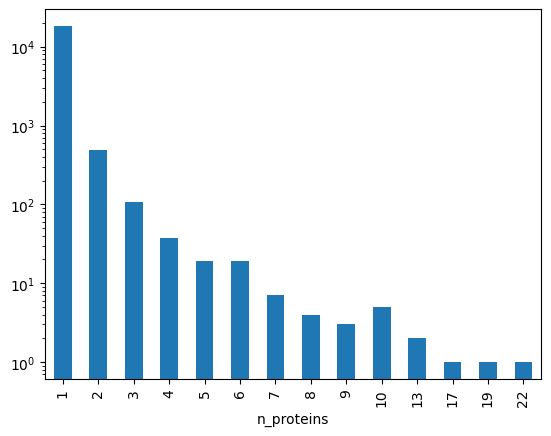

In [20]:
# create a df with clusters as entry
uniref_df = uniref_df.groupby('UniRef50_Cluster').agg({
    'protein': list,
    'gene': list,
}).reset_index()

# count
uniref_df["n_proteins"] = uniref_df.protein.apply(len)
uniref_df["n_genes"] = uniref_df.gene.apply(len)
uniref_df.sort_values(by="n_proteins", inplace=True, ascending=False)

# plot
display(uniref_df)
uniref_df.n_proteins.value_counts().sort_index().plot(kind="bar", logy=True)

In [ ]:
# CHECK: genes or proteins shared acorss clusters

# explode the lists into one row per (cluster, protein)
protein_cluster_map = uniref_df.explode("protein")[["UniRef50_Cluster", "protein"]].dropna()
gene_cluster_map = uniref_df.explode("gene")[["UniRef50_Cluster", "gene"]].dropna()

# group by protein and collect all clusters that contain it
protein_to_clusters = protein_cluster_map.groupby("protein")["UniRef50_Cluster"].unique()
gene_to_clusters = gene_cluster_map.groupby("gene")["UniRef50_Cluster"].unique()

# keep only proteins that occur in >1 cluster
shared_proteins = protein_to_clusters[protein_to_clusters.apply(len) > 1]
shared_genes = gene_to_clusters[gene_to_clusters.apply(len) > 1]

print(f"{len(shared_proteins)} proteins are shared between clusters")
display(shared_proteins.head())
print(f"{len(shared_genes)} genes are shared between clusters")
display(shared_genes.head())


0 proteins are shared between clusters


Series([], Name: UniRef50_Cluster, dtype: object)

0 genes are shared between clusters


Series([], Name: UniRef50_Cluster, dtype: object)

## Mark positive genes and clusters

cluster_label
negative    15260
positive     3727
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive
3432,UniRef50_P0DMV8,"[P0DMV8, P0DMV9, P34931]","[HSPA1A, HSPA1B, HSPA1L]",3,3,positive,"[P0DMV8, P0DMV9, P34931]","[HSPA1A, HSPA1B, HSPA1L]",3
2652,UniRef50_O95997,"[O95997, Q9NZH5, Q9NZH4]","[PTTG1, PTTG2, PTTG3P]",3,3,positive,"[O95997, Q9NZH5, Q9NZH4]","[PTTG1, PTTG2, PTTG3P]",3
9028,UniRef50_Q5TYM5,"[Q5TYM5, Q86X60, H0Y354, Q6L9T8]","[FAM72A, FAM72B, FAM72C, FAM72D]",4,4,positive,"[Q5TYM5, Q86X60, H0Y354]","[FAM72A, FAM72B, FAM72C]",3
2908,UniRef50_P04000,"[P04000, P04001, P0DN77, P0DN78]","[OPN1LW, OPN1MW, OPN1MW2, OPN1MW3]",4,4,positive,"[P04000, P04001, P0DN77]","[OPN1LW, OPN1MW, OPN1MW2]",3
3447,UniRef50_P0DP23,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3,3,positive,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3


(18987, 9)

<Axes: xlabel='n_genes_positive'>

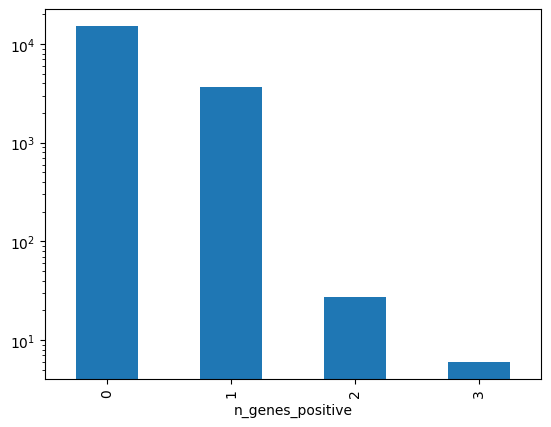

In [22]:
# Add the 'label' column: 'positive' if at least one protein maps to a positive gene, otherwise 'negative'
uniref_df["cluster_label"] = uniref_df["gene"].apply(
    lambda gene_list: "positive" 
    if any(g in positive_genes for g in gene_list)
    else "negative"
)

# plost how many postive genesets
print(uniref_df["cluster_label"].value_counts())#.sort_index().plot(kind="bar", logy=True,)

#########

# create list of genes AND CORREPSONDET prots that are postive (from above)

# unzip in parallel pritens_clened and genes_clened and create ritens_clened_psotive and genes_clened_positive 
    # maintain if proteins comes form psotive gene
uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if g in positive_genes],
        [g for g in row["gene"] if g in positive_genes]
    ),
    axis=1
))
uniref_df["n_genes_positive"] = uniref_df["genes_positive"].apply(len)
uniref_df.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(uniref_df.head(5))
display(uniref_df.shape)
uniref_df.n_genes_positive.value_counts().plot(kind="bar", logy=True)

In [23]:
# give probablities to be samped to each protein
uniref_df["logits"] = uniref_df["genes_positive"].apply(
    lambda gene_list: [positive_gene_freq_map.get(g, 0) for g in gene_list]
)
def safe_softmax(logits):
    if len(logits) == 0:
        return []  # return empty list if no logits
    return softmax(logits).tolist()  # convert numpy array to list
uniref_df["probs"] = uniref_df["logits"].apply(safe_softmax)

uniref_df.head(2)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs
3432,UniRef50_P0DMV8,"[P0DMV8, P0DMV9, P34931]","[HSPA1A, HSPA1B, HSPA1L]",3,3,positive,"[P0DMV8, P0DMV9, P34931]","[HSPA1A, HSPA1B, HSPA1L]",3,"[17, 16, 4]","[0.731057370606532, 0.268940976962995, 1.65243..."
2652,UniRef50_O95997,"[O95997, Q9NZH5, Q9NZH4]","[PTTG1, PTTG2, PTTG3P]",3,3,positive,"[O95997, Q9NZH5, Q9NZH4]","[PTTG1, PTTG2, PTTG3P]",3,"[112, 7, 4]","[1.0, 2.506567475899953e-46, 1.247946462912951..."


In [ ]:
# Create list of putative negative genes/protein        
    # ATTENTION; putatove = neither postive neither ambigous
gene_to_exclude = ambiguos_genes.union(positive_genes)

uniref_df["putative_negative_proteins"], uniref_df["putative_negative_genes"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if g not in gene_to_exclude],
        [g for g in row["gene"] if g not in gene_to_exclude]
    ),
    axis=1
))

uniref_df["n_putative_negative_genes"] = uniref_df.putative_negative_genes.apply(len)

display(uniref_df.tail(5))


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes
6501,UniRef50_Q01415,[Q01415],[GALK2],1,1,negative,[],[],0,[],[],[],[],0
6502,UniRef50_Q01432,[Q01432],[AMPD3],1,1,negative,[],[],0,[],[],[],[],0
6503,UniRef50_Q01433,[Q01433],[AMPD2],1,1,negative,[],[],0,[],[],[Q01433],[AMPD2],1
11361,UniRef50_Q8IWB4,"[Q5TZJ5, Q5VYP0, Q5VU36, Q5VVP1, Q8IWB4, P0DKV...","[SPATA31A1, SPATA31A3, SPATA31A5, SPATA31A6, S...",7,7,negative,[],[],0,[],[],"[Q5TZJ5, Q5VYP0, Q5VU36, Q5VVP1, Q8IWB4, P0DKV...","[SPATA31A1, SPATA31A3, SPATA31A5, SPATA31A6, S...",7
9866,UniRef50_Q6RFH8,"[P0CJ85, P0CJ86, P0CJ87, P0CJ88, P0CJ89, P0CJ9...","[DUX4L2, DUX4L3, DUX4L4, DUX4L5, DUX4L6, DUX4L...",7,7,negative,[],[],0,[],[],"[P0CJ85, P0CJ86, P0CJ87, P0CJ88, P0CJ89, P0CJ9...","[DUX4L2, DUX4L3, DUX4L4, DUX4L5, DUX4L6, DUX4L...",7


# Plotting positive genes per cluster

fraction_positive
0.000000    15260
0.052632        1
0.058824        1
0.125000        1
0.142857        1
0.250000        2
0.333333        9
0.500000       59
0.666667        2
0.750000        2
1.000000     3649
Name: count, dtype: int64


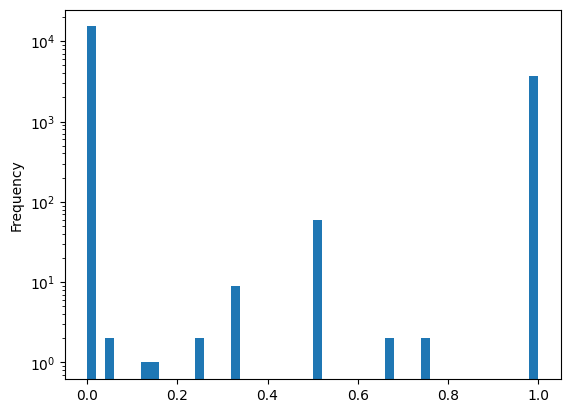

In [26]:
# FRACTION OF CLUSTER OCCUPIED BY POSITIVE GENES
uniref_df["fraction_positive"] = uniref_df.n_genes_positive / uniref_df.n_genes
uniref_df.sort_values(by="fraction_positive", inplace=True, ascending=False)

# hsit
uniref_df.fraction_positive.plot(kind="hist", logy=True, bins=50)
print(uniref_df.fraction_positive.value_counts().sort_index())


In [27]:
import pandas as pd
from scipy.stats import hypergeom, binom
import numpy as np

# Perform only on clusters wiht enogh cells
uniref_df_big_clusters = uniref_df[uniref_df.n_genes >= 5].copy()

# Calculate total genes and total positive genes across all clusters
total_genes = uniref_df_big_clusters['n_genes'].sum()
total_positive = uniref_df_big_clusters['n_genes_positive'].sum()

# Apply to each cluster - get both prob and pvalue in one go
results = uniref_df_big_clusters.apply(
    lambda row: pd.Series(dataf.per_cluster_hypergeom_test(row, total_genes, total_positive)), 
    axis=1
)
uniref_df_big_clusters['enrichment_prob'] = results[0]
uniref_df_big_clusters['enrichment_pvalue'] = results[1]

# Sort by p-value to see most significant clusters
uniref_df_results = uniref_df_big_clusters.sort_values('enrichment_pvalue')

print("Top enriched clusters:")
display(uniref_df_results[['n_genes', 'n_genes_positive', 'fraction_positive', 
                          'enrichment_prob', 'enrichment_pvalue']])

# Apply multiple testing correction (Bonferroni)
n_tests = len(uniref_df_big_clusters)
alpha = 0.05
bonferroni_threshold = alpha / n_tests

uniref_df_big_clusters['significant'] = uniref_df_big_clusters['enrichment_pvalue'] < bonferroni_threshold

print(f"\nNumber of significantly enriched clusters (Bonferroni corrected): {uniref_df_big_clusters['significant'].sum()}")
print(f"Bonferroni threshold: {bonferroni_threshold:.2e}")


Top enriched clusters:


,n_genes,n_genes_positive,fraction_positive,enrichment_prob,enrichment_pvalue
2094,7,1,0.142857,0.059628,0.060852
2882,8,1,0.125000,0.067686,0.069313
7023,17,1,0.058824,0.135225,0.142912
9864,19,1,0.052632,0.149049,0.158656
4770,10,0,0.000000,0.913937,1.000000
...,...,...,...,...,...
13469,6,0,0.000000,0.947667,1.000000
11361,7,0,0.000000,0.939148,1.000000
18731,13,0,0.000000,0.889238,1.000000
11076,22,0,0.000000,0.818135,1.000000



Number of significantly enriched clusters (Bonferroni corrected): 0
Bonferroni threshold: 8.06e-04


# Create Dataset

## Positive class sampling


In [31]:
# Filter only positive clusters
uniref_df_pos = uniref_df[uniref_df.cluster_label == "positive"].copy()

if not SAMPLE_POSITIVE_CLASS:
    MIN_SAMPLE_N_POSITIVE = uniref_df_pos.n_genes_positive.max()

uniref_df_pos["proteins_sampled"], uniref_df_pos["genes_sampled"] = zip(
    *uniref_df_pos.apply(
            dataf.sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=MIN_SAMPLE_N_POSITIVE, 
            gene_col="genes_positive",  # ATTENTION_: sample from correct columns
            prot_col="proteins_positive", 
            probs_col="probs")
)
uniref_df_pos["n_proteins_sampled"] = uniref_df_pos.proteins_sampled.apply(len)

display(uniref_df_pos.head(2))
print(uniref_df_pos.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
3988,UniRef50_P18075,"[P22004, P18075]","[BMP6, BMP7]",2,2,positive,"[P22004, P18075]","[BMP6, BMP7]",2,"[7, 20]","[2.2603242979035742e-06, 0.999997739675702]",[],[],0,1.0,"[P18075, P22004]","[BMP7, BMP6]",2
16540,UniRef50_Q9HC98,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2,2,positive,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2,"[19, 11]","[0.9996646498695336, 0.00033535013046647816]",[],[],0,1.0,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2


(3727, 18)


## Negative class sampling

In [32]:
# Filter only positive clusters
    # sample from clusters that do nto contain psotive (negative label of before)
    # 
uniref_df_neg = uniref_df[(uniref_df.n_putative_negative_genes > 0) & (uniref_df.cluster_label == "negative")].copy() 

uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = zip(
    *uniref_df_neg.apply(
            dataf.sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=MIN_SAMPLE_N_POSITIVE, 
            gene_col="putative_negative_genes", 
            prot_col="putative_negative_proteins", 
            probs_col=None # uniform
            )
)
uniref_df_neg["n_proteins_sampled"] = uniref_df_neg.proteins_sampled.apply(len)

# ATTENTION: same clusters coudl have 0 proteins to sample from (all proteins are postive OR ambigous so nothing left to sample as negative)
uniref_df_neg = uniref_df_neg[uniref_df_neg.n_proteins_sampled > 0]

display(uniref_df_neg.head())
print(uniref_df_neg.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
4770,UniRef50_P35125-3,"[Q8IZP1, A6NDS4, Q6IPX1, A0A087WVF3, A0A087X17...","[TBC1D3, TBC1D3B, TBC1D3C, TBC1D3D, TBC1D3E, T...",10,10,negative,[],[],0,[],[],"[Q8IZP1, A6NDS4, Q6IPX1, A0A087WVF3, A0A087X17...","[TBC1D3, TBC1D3B, TBC1D3C, TBC1D3D, TBC1D3E, T...",10,0.0,"[Q6DHY5, A6NER0, A0A087WVF3]","[TBC1D3G, TBC1D3F, TBC1D3D]",3
12479,UniRef50_Q8NFV5,"[Q8NFV5, A6NNV3, P0DV79, Q495Y8, A0A494C086, A...","[SPDYE1, SPDYE16, SPDYE18, SPDYE2, SPDYE21, SP...",8,8,negative,[],[],0,[],[],"[Q8NFV5, A6NNV3, P0DV79, A0A494C086, A6NHP3, A...","[SPDYE1, SPDYE16, SPDYE18, SPDYE21, SPDYE2B, S...",7,0.0,"[A0A494C086, A6NIY4, P0CI01]","[SPDYE21, SPDYE5, SPDYE6]",3
3482,UniRef50_P0DUX0,"[P0DUX0, P0DTA3, P0DUX1, A0A494C0Z2, P0DUD3, P...","[SPDYE10, SPDYE11, SPDYE12, SPDYE13, SPDYE14, ...",9,9,negative,[],[],0,[],[],"[P0DUX0, P0DTA3, P0DUX1, A0A494C0Z2, P0DUD3, P...","[SPDYE10, SPDYE11, SPDYE12, SPDYE13, SPDYE14, ...",9,0.0,"[A0A494C0Z2, P0DUD3, P0DTA3]","[SPDYE13, SPDYE14, SPDYE11]",3
8625,UniRef50_Q5HYN5,"[Q5HYN5, P0DMU9, Q5DJT8, Q8NHU0, P0DMU8, P0DMU...","[CT45A1, CT45A10, CT45A2, CT45A3, CT45A5, CT45...",9,9,negative,[],[],0,[],[],"[Q5HYN5, P0DMU9, Q5DJT8, Q8NHU0, P0DMU7, P0DMV...","[CT45A1, CT45A10, CT45A2, CT45A3, CT45A6, CT45...",8,0.0,"[P0DMV2, P0DMU9, P0DMV0]","[CT45A9, CT45A10, CT45A7]",3
466,UniRef50_A6NC78,"[A6NN73, P0DX52, P0DX53, A6NC78, A6NMD2, D6RF3...","[GOLGA8CP, GOLGA8F, GOLGA8G, GOLGA8IP, GOLGA8J...",10,10,negative,[],[],0,[],[],"[A6NN73, P0DX52, P0DX53, A6NC78, A6NMD2, D6RF3...","[GOLGA8CP, GOLGA8F, GOLGA8G, GOLGA8IP, GOLGA8J...",10,0.0,"[H3BSY2, P0DX52, D6RF30]","[GOLGA8M, GOLGA8F, GOLGA8K]",3


(10078, 18)


## Make dataset

Final df shoudl be:
- | Cluster | protein name | label | seq |

In [33]:
# add labels
uniref_df_pos["label_single_prot"] = 1
uniref_df_neg["label_single_prot"] = 0

# merge --> each entry is a cluster
dataset_df = pd.concat([uniref_df_pos, uniref_df_neg])
display(dataset_df.head())


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled,label_single_prot
3988,UniRef50_P18075,"[P22004, P18075]","[BMP6, BMP7]",2,2,positive,"[P22004, P18075]","[BMP6, BMP7]",2,"[7, 20]","[2.2603242979035742e-06, 0.999997739675702]",[],[],0,1.0,"[P18075, P22004]","[BMP7, BMP6]",2,1
16540,UniRef50_Q9HC98,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2,2,positive,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2,"[19, 11]","[0.9996646498695336, 0.00033535013046647816]",[],[],0,1.0,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2,1
7176,UniRef50_Q13490,"[Q13490, Q13489]","[BIRC2, BIRC3]",2,2,positive,"[Q13490, Q13489]","[BIRC2, BIRC3]",2,"[7, 3]","[0.9820137900379085, 0.017986209962091555]",[],[],0,1.0,"[Q13490, Q13489]","[BIRC2, BIRC3]",2,1
5122,UniRef50_P43405,"[P43405, P43403]","[SYK, ZAP70]",2,2,positive,"[P43405, P43403]","[SYK, ZAP70]",2,"[12, 12]","[0.5, 0.5]",[],[],0,1.0,"[P43405, P43403]","[SYK, ZAP70]",2,1
986,UniRef50_O00139,"[O00139, Q99661]","[KIF2A, KIF2C]",2,2,positive,"[O00139, Q99661]","[KIF2A, KIF2C]",2,"[17, 112]","[5.5210822770285325e-42, 1.0]",[],[],0,1.0,"[Q99661, O00139]","[KIF2C, KIF2A]",2,1


In [ ]:
# smaller df
cols_to_keep = ['UniRef50_Cluster', 'proteins_sampled',
                'genes_sampled', 'label_single_prot']
dataset_df_small = dataset_df[cols_to_keep].copy()

display(dataset_df_small)
print("ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins")
print(len(set(gene for sublist in dataset_df_small['proteins_sampled'] for gene in sublist)), "/ ~20000")

# Create a new DataFrame where each row corresponds to a (protein, gene) pair
rows = []
for _, row in dataset_df_small.iterrows():
    cluster = row["UniRef50_Cluster"]
    label = row["label_single_prot"]
    proteins = row["proteins_sampled"]
    genes = row["genes_sampled"]

    # zip ensures 1-to-1 pairing between proteins and genes
    for prot, gene in zip(proteins, genes):
        rows.append({
            "UniRef50_Cluster": cluster,
            "protein": prot,
            "gene": gene,
            "label": label
        })

df_long = pd.DataFrame(rows)

# checj fro duplcates
print("\nDuplicated rows/proteins: ", df_long.shape[0] - df_long.protein.nunique())

df_long

,UniRef50_Cluster,proteins_sampled,genes_sampled,label_single_prot
3988,UniRef50_P18075,"[P18075, P22004]","[BMP7, BMP6]",1
16540,UniRef50_Q9HC98,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",1
7176,UniRef50_Q13490,"[Q13490, Q13489]","[BIRC2, BIRC3]",1
5122,UniRef50_P43405,"[P43405, P43403]","[SYK, ZAP70]",1
986,UniRef50_O00139,"[Q99661, O00139]","[KIF2C, KIF2A]",1
...,...,...,...,...
6525,UniRef50_Q01726,[Q01726],[MC1R],0
6524,UniRef50_Q01718,[Q01718],[MC2R],0
11076,UniRef50_Q86YD7,"[A8MXZ1, P0C7X0, A6NDY2]","[FAM90A23, FAM90A24, FAM90A10]",0
9866,UniRef50_Q6RFH8,"[Q6RFH8, P0CJ86, P0CJ85]","[DUX4L9, DUX4L3, DUX4L2]",0


ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins
14451 / 20000

Duplicated rows/proteins:  0


,UniRef50_Cluster,protein,gene,label
0,UniRef50_P18075,P18075,BMP7,1
1,UniRef50_P18075,P22004,BMP6,1
2,UniRef50_Q9HC98,Q9HC98,NEK6,1
3,UniRef50_Q9HC98,Q8TDX7,NEK7,1
4,UniRef50_Q13490,Q13490,BIRC2,1
...,...,...,...,...
14446,UniRef50_Q86YD7,A6NDY2,FAM90A10,0
14447,UniRef50_Q6RFH8,Q6RFH8,DUX4L9,0
14448,UniRef50_Q6RFH8,P0CJ86,DUX4L3,0
14449,UniRef50_Q6RFH8,P0CJ85,DUX4L2,0


# Assure 1:3 ratio in postive and negative class
After this sampling you will have (done LATER in notebook)
- | pos prot | << | neg prot | → more thna 1:3 ration
- Need to subsampled negative class
- Subsample negative class
    - Subsample the remaining cluster to have a final ratio 1:3

In [35]:
# list of smpled positve proteins
positive_proteins_tmp = set(df_long[df_long.label == 1]["protein"].unique())

# list of prtein in MIXED cluster (wiht inside btoh postive and negative prteins)
    # ATTENTUON: check no ptortien in mixed clusters
proteins_in_mixed_clusters = df_long.groupby('UniRef50_Cluster').filter(lambda x: x['label'].nunique() > 1).sort_values(by="UniRef50_Cluster")
print("priteins in mixed clusters:", len(proteins_in_mixed_clusters))
proteins_in_mixed_clusters = set(proteins_in_mixed_clusters["protein"].unique())

# proteins to NOT remove
proteins_not_to_remove = proteins_in_mixed_clusters.union(positive_proteins_tmp)

# give col
df_long["can_be_removed"] = ~df_long["protein"].isin(proteins_not_to_remove)

df_long

priteins in mixed clusters: 0


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_P18075,P18075,BMP7,1,False
1,UniRef50_P18075,P22004,BMP6,1,False
2,UniRef50_Q9HC98,Q9HC98,NEK6,1,False
3,UniRef50_Q9HC98,Q8TDX7,NEK7,1,False
4,UniRef50_Q13490,Q13490,BIRC2,1,False
...,...,...,...,...,...
14446,UniRef50_Q86YD7,A6NDY2,FAM90A10,0,True
14447,UniRef50_Q6RFH8,Q6RFH8,DUX4L9,0,True
14448,UniRef50_Q6RFH8,P0CJ86,DUX4L3,0,True
14449,UniRef50_Q6RFH8,P0CJ85,DUX4L2,0,True


In [36]:
# decide fraction to susample

# Number of positive proteins
n_positive = df_long[df_long["label"] == 1].shape[0]
# Number desidered negative
n_desired_negatives = n_positive * NEGATIVE_CLASS_MULT
# Removable (negative) proteins
removable_negatives = df_long[(df_long["label"] == 0) & (df_long["can_be_removed"])]
# Determine fraction to subsample
frac_to_sample = n_desired_negatives / len(removable_negatives)
frac_to_sample = min(frac_to_sample, 1.0)  # cannot sample more than available

frac_to_sample

1.0

In [37]:

# susample
removable = df_long[df_long["can_be_removed"]]
keep = df_long[~df_long["can_be_removed"]]

subsampled_removable = removable.sample(frac=frac_to_sample, random_state=SEED)

df_subsampled = pd.concat([keep, subsampled_removable]).reset_index(drop=True) # Combine back with the protected proteins

print(df_subsampled.label.value_counts())
df_subsampled

label
0    10685
1     3766
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_P18075,P18075,BMP7,1,False
1,UniRef50_P18075,P22004,BMP6,1,False
2,UniRef50_Q9HC98,Q9HC98,NEK6,1,False
3,UniRef50_Q9HC98,Q8TDX7,NEK7,1,False
4,UniRef50_Q13490,Q13490,BIRC2,1,False
...,...,...,...,...,...
14446,UniRef50_A0A1B0GVT2,A0A1B0GVT2,SMIM36,0,True
14447,UniRef50_P23025,P23025,XPA,0,True
14448,UniRef50_C9JFL3,C9JFL3,PHGR1,0,True
14449,UniRef50_Q8IXR9,Q8IXR9,C12orf56,0,True


## Give Seq


In [38]:
### create df to join
join_df_tmp = proteome_uniprot[["Entry", "Sequence"]].copy().rename(columns={"Sequence": "sequence"})

# join
    # ATTNETION: we shoudl NOT lose any col
long_df_seq = pd.merge(how="inner", left=df_subsampled, right=join_df_tmp, left_on="protein", right_on="Entry")

# drp cols
long_df_seq.drop(columns=["can_be_removed", "Entry"], inplace=True)

long_df_seq

,UniRef50_Cluster,protein,gene,label,sequence
0,UniRef50_P18075,P18075,BMP7,1,MHVRSLRAAAPHSFVALWAPLFLLRSALADFSLDNEVHSSFIHRRL...
1,UniRef50_P18075,P22004,BMP6,1,MPGLGRRAQWLCWWWGLLCSCCGPPPLRPPLPAAAAAAAGGQLLGD...
2,UniRef50_Q9HC98,Q9HC98,NEK6,1,MAGQPGHMPHGGSSNNLCHTLGPVHPPDPQRHPNTLSFRCSLADFQ...
3,UniRef50_Q9HC98,Q8TDX7,NEK7,1,MDEQSQGMQGPPVPQFQPQKALRPDMGYNTLANFRIEKKIGRGQFS...
4,UniRef50_Q13490,Q13490,BIRC2,1,MHKTASQRLFPGPSYQNIKSIMEDSTILSDWTNSNKQKMKYDFSCE...
...,...,...,...,...,...
14446,UniRef50_A0A1B0GVT2,A0A1B0GVT2,SMIM36,0,MEFYLEIDPVTLNLIILVASYVILLLVFLISCVLYDCRGKDPSKEY...
14447,UniRef50_P23025,P23025,XPA,0,MAAADGALPEAAALEQPAELPASVRASIERKRQRALMLRQARLAAR...
14448,UniRef50_C9JFL3,C9JFL3,PHGR1,0,MDPGPKGHCHCGGHGHPPGHCGPPPGHGPGPCGPPPHHGPGPCGPP...
14449,UniRef50_Q8IXR9,Q8IXR9,C12orf56,0,MASPLPSGFPARRNSRLDVFLRRHLPPEVYDAVRAYEPCIVVSNSE...


## Stratify dataset

We can stratify based on many metrics:
1. labels
2. PREVALENT metric
3. **based on cluster**
    - Put proteins coming from same cluster in different sets or not

In [39]:
from sklearn.model_selection import train_test_split
import pandas as pd

# --- group-level stratified split ---

# pslit by cluster and then ive back set-label to each row

# One representative row per UniRef50_Cluster
cluster_df = long_df_seq.groupby('UniRef50_Cluster').first().reset_index()

# Stratified split by label, but at the cluster level
    # ists of unique cluster IDs.
train_clusters, temp_clusters = train_test_split(
    cluster_df['UniRef50_Cluster'],
    test_size=0.2,
    stratify=cluster_df['label'],
    random_state=42
)

# Split the temporary set equally into validation and test
temp_labels = cluster_df.loc[cluster_df['UniRef50_Cluster'].isin(temp_clusters), 'label']
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# --- assign back to the full dataframe ---
#Every row in long_df_seq inherits its set label based on its UniRef50_Cluster
long_df_seq['set'] = ''
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(train_clusters), 'set'] = 'train'
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(val_clusters), 'set'] = 'val'
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(test_clusters), 'set'] = 'test'

# Check split distribution
print(long_df_seq.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(long_df_seq)


label     0     1
set              
test   1059   384
train  8546  3016
val    1080   366


,UniRef50_Cluster,protein,gene,label,sequence,set
0,UniRef50_P18075,P18075,BMP7,1,MHVRSLRAAAPHSFVALWAPLFLLRSALADFSLDNEVHSSFIHRRL...,train
1,UniRef50_P18075,P22004,BMP6,1,MPGLGRRAQWLCWWWGLLCSCCGPPPLRPPLPAAAAAAAGGQLLGD...,train
2,UniRef50_Q9HC98,Q9HC98,NEK6,1,MAGQPGHMPHGGSSNNLCHTLGPVHPPDPQRHPNTLSFRCSLADFQ...,train
3,UniRef50_Q9HC98,Q8TDX7,NEK7,1,MDEQSQGMQGPPVPQFQPQKALRPDMGYNTLANFRIEKKIGRGQFS...,train
4,UniRef50_Q13490,Q13490,BIRC2,1,MHKTASQRLFPGPSYQNIKSIMEDSTILSDWTNSNKQKMKYDFSCE...,train
...,...,...,...,...,...,...
14446,UniRef50_A0A1B0GVT2,A0A1B0GVT2,SMIM36,0,MEFYLEIDPVTLNLIILVASYVILLLVFLISCVLYDCRGKDPSKEY...,test
14447,UniRef50_P23025,P23025,XPA,0,MAAADGALPEAAALEQPAELPASVRASIERKRQRALMLRQARLAAR...,train
14448,UniRef50_C9JFL3,C9JFL3,PHGR1,0,MDPGPKGHCHCGGHGHPPGHCGPPPGHGPGPCGPPPHHGPGPCGPP...,train
14449,UniRef50_Q8IXR9,Q8IXR9,C12orf56,0,MASPLPSGFPARRNSRLDVFLRRHLPPEVYDAVRAYEPCIVVSNSE...,train


## Save

In [40]:
long_df_seq.to_csv(FINAL_DATASET_PATH)
FINAL_DATASET_PATH

'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/dataset-cell-cycle_2:3.csv'

# ------------------------------

In [ ]:
from Bio import SeqIO
import pandas as pd

# Parse all sequences in the FASTA file
records = list(SeqIO.parse("/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/0_class_yu_et_all.fasta", "fasta"))
data = {
    "protein": [record.id for record in records],
    "sequence": [str(record.seq) for record in records],
    "label": [0 for record in records],
}
df_neg = pd.DataFrame(data)
print(df_neg.shape)


records = list(SeqIO.parse("/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/1_class_yu_et_all.fasta", "fasta"))
data = {
    "protein": [record.id for record in records],
    "sequence": [str(record.seq) for record in records],
    "label": [1 for record in records],
}
df_pos = pd.DataFrame(data)
print(df_pos.shape)

df = pd.concat([df_neg, df_pos])

df


In [ ]:
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Assign splits
df['set'] = ''
df.loc[train_idx, 'set'] = 'train'
df.loc[test_idx, 'set'] = 'test'
df.loc[test_idx[0], 'set'] = 'val' #just temp
df.reset_index(drop=True, inplace=True)
df["protein"] = range(df["protein"].shape[0])

print(df.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(df)
df

In [ ]:
df.iloc[[332]].sequence.to_list()

In [ ]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/yu_et_all_cyclins.csv")